<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/%22Data_AI_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import glob

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from torchsummary import summary
import pathlib
from PIL import Image
from torchvision.transforms import transforms
from torch.optim import Adam

import torchvision.transforms as T

In [2]:
!pip install torchinfo

#Kompiyuter va telifon

In [20]:
! wget -O dataset.zip https://www.dropbox.com/s/e5f4epncmydijrw/Komp_in_tel.zip?dl=0

--2023-07-10 18:54:19--  https://www.dropbox.com/s/e5f4epncmydijrw/Komp_in_tel.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/e5f4epncmydijrw/Komp_in_tel.zip [following]
--2023-07-10 18:54:20--  https://www.dropbox.com/s/raw/e5f4epncmydijrw/Komp_in_tel.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4df43d8ee6ee163d6714737e75.dl.dropboxusercontent.com/cd/0/inline/B_lws7Zle2dlogfV2GE0pRChQd6MuyteJLS1bv6Obc7TkSMrIcxNUTxEOUqVUhbXisoIeBoiL7UyqrqSXld8j_hhaiu5IwDMz-kxtJRfX8RZGqqGyW8NubKiI_pKBGE45jeR2d8yTB1320ztrcPtL_q9wyI4M8kwEIo5dKZ7R0qQjA/file# [following]
--2023-07-10 18:54:20--  https://uc4df43d8ee6ee163d6714737e75.dl.dropboxusercontent.com/cd/0/inline/B_lws7Zle2dlogfV2GE0pRChQd6MuyteJLS1bv6Obc7TkSMrIcxNUTxEOUqVUhbXi

In [ ]:
!unzip dataset.zip

In [166]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [167]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [168]:
class KOMP_in_tel_Dataset(Dataset):
    def __init__(self, path, transform = None):
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform
    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'kompiyuter' in label else 1
        if transform != None:
            img = transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.path_list)

In [169]:
train_path = pathlib.Path('/content/Komp_in_tel/train')
test_path = pathlib.Path('/content/Komp_in_tel/validation')

In [170]:
train_dataset = KOMP_in_tel_Dataset(train_path, transform)
test_dataset = KOMP_in_tel_Dataset(test_path, transform)

In [171]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [172]:
train_data = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=50, shuffle=True)

In [173]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output


In [174]:
model=ConvNet()

In [175]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [176]:
num_epochs = 5

In [177]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n
        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)
        return train_loss, train_accuracy
    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)
        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)
        return val_loss, val_accuracy
    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [178]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [179]:
trainer.train()

100%|██████████| 1/1 [00:00<00:00, 10.97it/s]



Epoch[1/5] 	 train_loss: 6.03382, train_acc: 0.62 	 val_loss: 7.32580 	 val_acc: 0.7


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]



Epoch[2/5] 	 train_loss: 3.99455, train_acc: 0.85 	 val_loss: 5.75101 	 val_acc: 0.6


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]



Epoch[3/5] 	 train_loss: 2.39932, train_acc: 0.87 	 val_loss: 0.00000 	 val_acc: 1.0


100%|██████████| 1/1 [00:00<00:00,  7.75it/s]



Epoch[4/5] 	 train_loss: 0.99552, train_acc: 0.93 	 val_loss: 0.00000 	 val_acc: 1.0


100%|██████████| 1/1 [00:00<00:00, 11.08it/s]


Epoch[5/5] 	 train_loss: 0.46252, train_acc: 0.97 	 val_loss: 3.30386 	 val_acc: 0.8


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
[[0 0]
 [2 8]]


<Axes: >

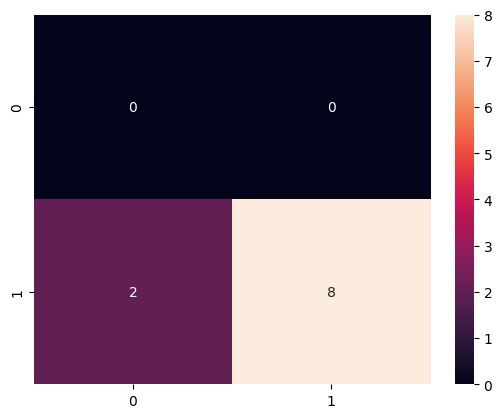

In [180]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

#Stol kompiyuteri va novutbuk

In [59]:
! wget -O dataset.zip https://www.dropbox.com/s/fdlnoh5stmumy0d/Kompiyuter.zip?dl=0

--2023-07-10 18:59:53--  https://www.dropbox.com/s/fdlnoh5stmumy0d/Kompiyuter.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/fdlnoh5stmumy0d/Kompiyuter.zip [following]
--2023-07-10 18:59:53--  https://www.dropbox.com/s/raw/fdlnoh5stmumy0d/Kompiyuter.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc662858fb43c6c3faa0315d39ee.dl.dropboxusercontent.com/cd/0/inline/B_mgU6VKUg_5XDO-6DJJ6l4eB0EBwqZVxl8438jVILZO73QtrTwYFNPtIIBbRZme0fu8lHvuo620YBGqckjNsmE7xq-QjnaNuS-F9Zij0UT75Wx79PPpokjg3xPTS-GAehNLAnPw0o3OPkrrzGBS6FXAdxQ2T0CJKJOFoierevhYnw/file# [following]
--2023-07-10 18:59:54--  https://uc662858fb43c6c3faa0315d39ee.dl.dropboxusercontent.com/cd/0/inline/B_mgU6VKUg_5XDO-6DJJ6l4eB0EBwqZVxl8438jVILZO73QtrTwYFNPtIIBbRZme0fu8l

In [ ]:
!unzip dataset.zip

In [62]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [63]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [153]:
class KompyuterDataset(Dataset):
    def __init__(self, path, transform = None):
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform
    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'kompiyuter' in label else 1
        if transform != None:
            img = transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.path_list)

In [154]:
train_path = pathlib.Path('/content/Kompiyuter/train')
test_path = pathlib.Path('/content/Kompiyuter/validation')

In [155]:
train_dataset = KompyuterDataset(train_path, transform)
test_dataset = KompyuterDataset(test_path, transform)

In [156]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [157]:
train_data = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=50, shuffle=True)

In [158]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output


In [159]:
model=ConvNet()

In [160]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [161]:
num_epochs = 5

In [162]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n
        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)
        return train_loss, train_accuracy
    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)
        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)
        return val_loss, val_accuracy
    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [163]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [164]:
trainer.train()

100%|██████████| 1/1 [00:00<00:00,  5.46it/s]



Epoch[1/5] 	 train_loss: 23.66635, train_acc: 0.42 	 val_loss: 2.90132 	 val_acc: 0.65


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]



Epoch[2/5] 	 train_loss: 15.83187, train_acc: 0.66 	 val_loss: 21.39245 	 val_acc: 0.5


100%|██████████| 1/1 [00:00<00:00,  5.30it/s]



Epoch[3/5] 	 train_loss: 10.03863, train_acc: 0.65 	 val_loss: 12.23822 	 val_acc: 0.5


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]



Epoch[4/5] 	 train_loss: 9.71026, train_acc: 0.58 	 val_loss: 17.39186 	 val_acc: 0.5


100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


Epoch[5/5] 	 train_loss: 3.45240, train_acc: 0.79 	 val_loss: 4.28478 	 val_acc: 0.75


tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1])
[[8 2]
 [3 7]]


<Axes: >

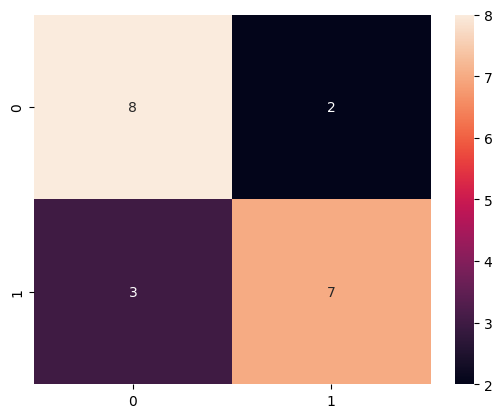

In [165]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)

#Teztibbiy yordam va Politsiya moshinalari

In [3]:
! wget -O tezyordam_in_polis.zip https://www.dropbox.com/s/zbrbvyj6la2jivv/Tez_in_polis.zip?dl=0

--2023-07-10 18:48:44--  https://www.dropbox.com/s/zbrbvyj6la2jivv/Tez_in_polis.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zbrbvyj6la2jivv/Tez_in_polis.zip [following]
--2023-07-10 18:48:51--  https://www.dropbox.com/s/raw/zbrbvyj6la2jivv/Tez_in_polis.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc227d26a4abf792617a5fdc001f.dl.dropboxusercontent.com/cd/0/inline/B_mzwGL-W60oUthNovdLjPo42n_7i509P3ijtbMeqVfLzLVMWkewhetHjK8az1-aQ3SRlHDvHSzh-WqGy7k_qVNQ2Tn-KD-7eZ0w3J-XzzzalhtHZJD1TopbBF-TcpnLX5la7ZDD58i8fePFmYnizer3fsA91rM_cPuyyNuxNwzMgg/file# [following]
--2023-07-10 18:48:52--  https://uc227d26a4abf792617a5fdc001f.dl.dropboxusercontent.com/cd/0/inline/B_mzwGL-W60oUthNovdLjPo42n_7i509P3ijtbMeqVfLzLVMWkewhetHjK8az1

In [4]:
!unzip tezyordam_in_polis.zip

Archive:  tezyordam_in_polis.zip
   creating: Tez_in_polis/
   creating: Tez_in_polis/test/
   creating: Tez_in_polis/test/Polis/
  inflating: Tez_in_polis/test/Polis/download11.jpg  
  inflating: Tez_in_polis/test/Polis/download12.jpg  
  inflating: Tez_in_polis/test/Polis/download23.jpg  
  inflating: Tez_in_polis/test/Polis/download24.jpg  
  inflating: Tez_in_polis/test/Polis/download25.jpg  
  inflating: Tez_in_polis/test/Polis/download5.jpg  
  inflating: Tez_in_polis/test/Polis/download6.jpg  
  inflating: Tez_in_polis/test/Polis/images (1).jpg  
  inflating: Tez_in_polis/test/Polis/images (10).jpg  
  inflating: Tez_in_polis/test/Polis/images (13).jpg  
  inflating: Tez_in_polis/test/Polis/images (14).jpg  
  inflating: Tez_in_polis/test/Polis/images (15).jpg  
  inflating: Tez_in_polis/test/Polis/images (16).jpg  
  inflating: Tez_in_polis/test/Polis/images (17).jpg  
  inflating: Tez_in_polis/test/Polis/images (18).jpg  
  inflating: Tez_in_polis/test/Polis/images (19).jpg  


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [7]:
class Tez_in_pol_Dataset(Dataset):
    def __init__(self, path, transform = None):
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform
    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'Polis' in label else 1
        if transform != None:
            img = transform(img)
        return img, int(label)
    def __len__(self):
        return len(self.path_list)

In [8]:
train_path = pathlib.Path('/content/Tez_in_polis/tren')
test_path = pathlib.Path('/content/Tez_in_polis/test')

In [9]:
train_dataset = Tez_in_pol_Dataset(train_path, transform)
test_dataset = Tez_in_pol_Dataset(test_path, transform)

In [10]:
path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

In [11]:
train_data = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [12]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=12)
        self.relu1=nn.ReLU()
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3=nn.BatchNorm2d(num_features=32)
        self.relu3=nn.ReLU()

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool(output)
        output=self.conv2(output)
        output=self.relu2(output)
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
        output=output.view(-1,32*75*75)
        output=self.fc(output)
        return output


In [13]:
model=ConvNet()

In [14]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [15]:
num_epochs = 5

In [16]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n
        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)
        return train_loss, train_accuracy
    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            output = self.model(data)
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)
        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)
        return val_loss, val_accuracy
    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [17]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [18]:
trainer.train()

100%|██████████| 6/6 [00:00<00:00,  6.93it/s]



Epoch[1/5] 	 train_loss: 5.71680, train_acc: 0.81 	 val_loss: 5.95225 	 val_acc: 0.72


100%|██████████| 6/6 [00:00<00:00,  8.05it/s]



Epoch[2/5] 	 train_loss: 1.36950, train_acc: 0.93 	 val_loss: 2.97816 	 val_acc: 0.87


100%|██████████| 6/6 [00:00<00:00, 10.04it/s]



Epoch[3/5] 	 train_loss: 0.20168, train_acc: 0.98 	 val_loss: 3.02377 	 val_acc: 0.88


100%|██████████| 6/6 [00:01<00:00,  4.06it/s]



Epoch[4/5] 	 train_loss: 0.01808, train_acc: 1.00 	 val_loss: 2.31848 	 val_acc: 0.88


100%|██████████| 6/6 [00:00<00:00,  8.10it/s]


Epoch[5/5] 	 train_loss: 0.07736, train_acc: 0.99 	 val_loss: 1.18370 	 val_acc: 0.92


tensor([0, 0, 1, 1, 1, 1, 0, 0, 0, 1])
[[5 0]
 [1 4]]


<Axes: >

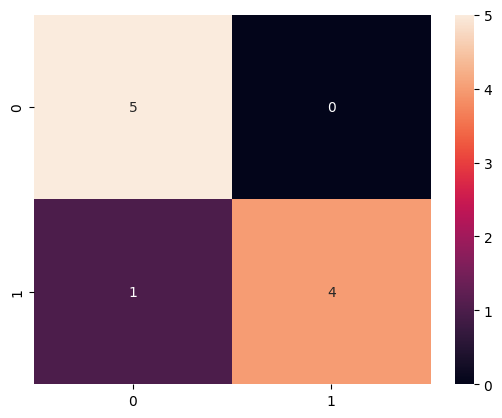

In [19]:
test_img,test_label=next(iter(test_data))
pred=model(test_img.to(device))
pred=pred.argmax(axis=1)
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
print( test_label)
cm=confusion_matrix(test_label,pred)
print(cm)
import seaborn as sns
sns.heatmap(cm,annot=True)